In [30]:
import jax

import jax.numpy as np
import jax.scipy as sp
from numpy.polynomial.hermite import hermgauss

import vb_lib.structure_optimization_lib as s_optim_lib
from vb_lib import structure_model_lib, data_utils, cavi_lib, plotting_utils
from vb_lib.preconditioner_lib import get_mfvb_cov_matmul

from bnpmodeling_runjingdev import log_phi_lib, cluster_quantities_lib
from bnpmodeling_runjingdev.sensitivity_lib import HyperparameterSensitivityLinearApproximation
import bnpmodeling_runjingdev.exponential_families as ef

import paragami

from copy import deepcopy

import time

import matplotlib.pyplot as plt
%matplotlib inline  

from bnpmodeling_runjingdev import influence_lib, modeling_lib
import bnpmodeling_runjingdev.functional_sensitivity_lib as func_sens_lib
import bnpmodeling_runjingdev.influence_lib 

import re

In [31]:
import numpy as onp 
onp.random.seed(53453)

# Some model parameters

In [32]:
dp_prior_alpha = 6.0
k_approx = 10

In [33]:
gh_deg = 8
gh_loc, gh_weights = hermgauss(8)

# VB params

In [75]:
vb_params_dict, vb_params_paragami = \
    structure_model_lib.get_vb_params_paragami_object(n_obs = 1, n_loci = 1, 
                                                      k_approx = k_approx,
                                                      use_logitnormal_sticks = True)


# just keep the stick parameters
vb_params_dict = vb_params_dict['ind_admix_params']
vb_params_paragami = vb_params_paragami['ind_admix_params']

print(vb_params_paragami)

OrderedDict:
	[stick_means] = NumericArrayPattern (1, 9) (lb=-inf, ub=inf)
	[stick_infos] = NumericArrayPattern (1, 9) (lb=0.0, ub=inf)


# Define perturbation

In [76]:
f_obj_all = log_phi_lib.LogPhiPerturbations(vb_params_paragami, 
                                            dp_prior_alpha,
                                            gh_loc, 
                                            gh_weights,
                                            stick_key = 'ind_admix_params')

In [77]:
perturbation = 'sigmoidal_neg'

In [78]:
f_obj = getattr(f_obj_all, 'f_obj_' + perturbation)

In [91]:
means = vb_params_dict['stick_means'][0, 2]
infos = vb_params_dict['stick_infos'][0, 2]
f_obj.e_log_phi(means, infos)

DeviceArray(-0.30246421, dtype=float64)

In [92]:
import numpy as onp

In [93]:
n = 1000000
samples = f_obj.log_phi(onp.random.randn(n) * np.sqrt(1 / infos) + means)

In [94]:
samples.mean()

DeviceArray(-0.30299841, dtype=float64)

In [95]:
samples.std() / np.sqrt(n)

DeviceArray(0.00034858, dtype=float64)

# Define objective

In [9]:
n_obs = 200
# weights = onp.ones(k_approx) * 0.01
# weights[0] = 0.5
# weights[1] = 0.5
# weights = weights / weights.sum() * n_obs
weights = 0.

In [10]:
weights

0.0

In [11]:
def f(vb_free_params, epsilon = 0): 
    
    stick_params = vb_params_paragami.fold(vb_free_params, 
                                           free = True)
    
    means = stick_params['stick_means'] 
    infos = stick_params['stick_infos']
    
    e_log_sticks, e_log_1m_sticks = \
        ef.get_e_log_logitnormal(
            lognorm_means = means,
            lognorm_infos = infos,
            gh_loc = gh_loc,
            gh_weights = gh_weights)
    
    p0 = (dp_prior_alpha - 1) * e_log_1m_sticks.sum() 
    
    p_pert = f_obj.e_log_phi_epsilon(means, infos, epsilon)
    
    entropy = modeling_lib.get_stick_breaking_entropy(
                                    means,
                                    infos,
                                    gh_loc, gh_weights)
    
    e_log_weights = modeling_lib.\
        get_e_log_cluster_probabilities_from_e_log_stick(e_log_sticks, 
                                                         e_log_1m_sticks).squeeze()
    
    loglik = (e_log_weights * weights).sum()
    
    elbo = p0 + p_pert + entropy + loglik
                
    
    return -elbo

f = jax.jit(f)
grad = jax.jit(jax.grad(f, argnums = 0))

In [12]:
f_np = lambda x, epsilon : onp.array(f(x, epsilon))
grad_np = lambda x, epsilon : onp.array(grad(x, epsilon))

In [13]:
from scipy import optimize

In [14]:
epsilon = 0.

x0 = onp.array(vb_params_paragami.flatten(vb_params_dict, free = True))

out = optimize.minimize(lambda x : f_np(x, epsilon), 
                  x0 = x0,
                  jac = lambda x : grad_np(x, epsilon), 
                  method = 'BFGS')

vb_opt = out.x

In [15]:
vb_params_dict = vb_params_paragami.fold(vb_opt, free = True)

In [16]:
vb_params_dict

OrderedDict([('stick_means',
              array([[-2.21654085, -2.21654105, -2.21654216, -2.21654033, -2.21654179,
                      -2.21653956, -2.21653792, -2.2165429 , -2.21653902]])),
             ('stick_infos',
              DeviceArray([[0.73038671, 0.73038807, 0.73038721, 0.73038831, 0.73038754,
                            0.7303884 , 0.73038901, 0.73038669, 0.73038707]],            dtype=float64))])

# Fit at epsilon = 0

In [17]:
def get_logitnormal_pdf(v, mean, info): 
    
    x = sp.special.logit(v)
    
    jac_term = 1 / (v * (1 - v))
    
    return sp.stats.norm.pdf(x, loc = mean, scale = 1 / np.sqrt(info)) * jac_term
    

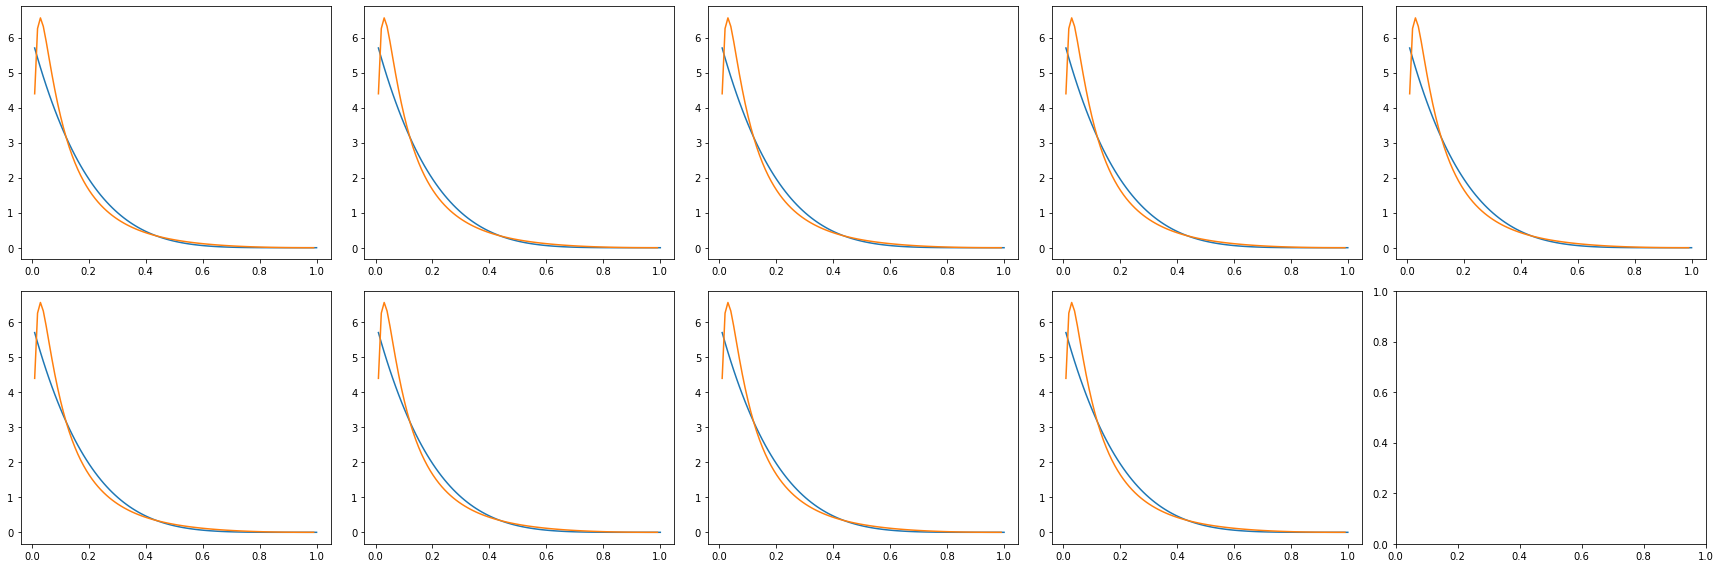

In [18]:
v = np.linspace(0, 1, 100)
beta_pdf = sp.stats.beta.pdf(v, a = 1, b = dp_prior_alpha)

fig, ax = plt.subplots(2, 5, figsize = (24, 8))

for i in range(k_approx - 1): 
    ax[i // 5, i % 5].plot(v, beta_pdf)
    ax[i // 5, i % 5].plot(v, get_logitnormal_pdf(v, 
                                                  vb_params_dict['stick_means'][0, i], 
                                                  vb_params_dict['stick_infos'][0, i]))

fig.tight_layout()

# Refit for a range of epsilons

In [19]:
delta = 5.
epsilon_vec = np.linspace(0, 1, 12)**2 * delta

In [20]:
vb_refit_list = []
x0 = vb_opt

for epsilon in epsilon_vec: 
    print('epsilon = ', epsilon)
    
    out = optimize.minimize(lambda x : f_np(x, epsilon), 
                  x0 = x0,
                  jac = lambda x : grad_np(x, epsilon), 
                  method = 'BFGS')
    
    
    print('kl: , ', out.fun)
    print('\n')
    vb_refit_list.append(out.x)
    
    x0 = out.x

epsilon =  0.0
kl: ,  16.52159122965243


epsilon =  0.04132231404958678
kl: ,  16.255491714215957


epsilon =  0.1652892561983471
kl: ,  15.451813511676384


epsilon =  0.3719008264462809
kl: ,  14.095094969413067


epsilon =  0.6611570247933884
kl: ,  12.161695506226678


epsilon =  1.0330578512396693
kl: ,  9.622563532850434


epsilon =  1.4876033057851237
kl: ,  6.446353476863245


epsilon =  2.024793388429752
kl: ,  2.602342742452297


epsilon =  2.644628099173554
kl: ,  -1.9372963621010992


epsilon =  3.3471074380165295
kl: ,  -7.196104014697552


epsilon =  4.132231404958677
kl: ,  -13.192813326765542


epsilon =  5.0
kl: ,  -19.941514438031184




In [21]:
vb_params_paragami.fold(vb_refit_list[-1], free = True)

OrderedDict([('stick_means',
              array([[-3.18424106, -3.18424106, -3.18424106, -3.18424106, -3.18424106,
                      -3.18424106, -3.18424106, -3.18424106, -3.18424106]])),
             ('stick_infos',
              DeviceArray([[0.79224149, 0.79224149, 0.79224149, 0.79224149, 0.79224149,
                            0.79224149, 0.79224149, 0.79224149, 0.79224149]],            dtype=float64))])

# Effect on parameters and expectations

In [22]:
def get_logitnormal_loc_param(vb_free_params): 
    vb_params_dict = vb_params_paragami.fold(vb_free_params, free = True)
    return vb_params_dict['stick_means'].squeeze()

In [23]:
def get_e_sticks(vb_free_params): 
    vb_params_dict = vb_params_paragami.fold(vb_free_params, free = True)
    
    lognorm_means = vb_params_dict['stick_means']
    lognorm_infos = vb_params_dict['stick_infos']
    
    return ef.get_e_logitnormal(lognorm_means, lognorm_infos, gh_loc, gh_weights).squeeze()

In [24]:
def get_e_ind_admix(vb_free_params): 
    
    vb_params_dict = vb_params_paragami.fold(vb_free_params, free = True)
    
    stick_means = vb_params_dict['stick_means']
    stick_infos = vb_params_dict['stick_infos']
    
    e_ind_admix = cluster_quantities_lib.get_e_cluster_probabilities(stick_means, 
                                                                     stick_infos, 
                                                                     gh_loc, 
                                                                     gh_weights)
    return e_ind_admix

In [25]:
location_array = []
e_sticks_array = []
e_admix_array = []

for i in range(len(epsilon_vec)): 
    location_array.append(get_logitnormal_loc_param(vb_refit_list[i]))
    e_sticks_array.append(get_e_sticks(vb_refit_list[i]))
    e_admix_array.append(get_e_ind_admix(vb_refit_list[i]))

location_array = np.array(location_array)
e_sticks_array = np.array(e_sticks_array)
e_admix_array = np.array(e_admix_array)

### effect on location parameter

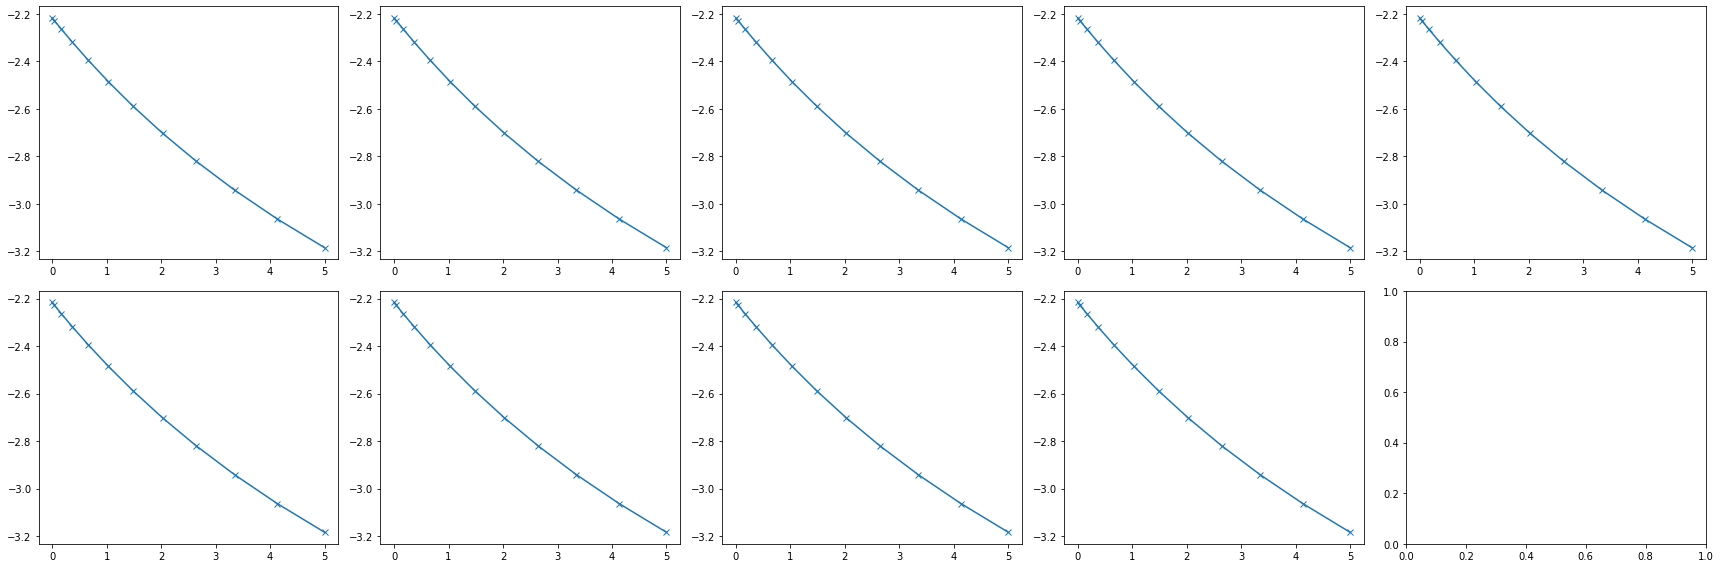

In [26]:
fig, ax = plt.subplots(2, 5, figsize = (24, 8))

for k in range(k_approx - 1): 
    ax[k // 5, k % 5].plot(epsilon_vec, location_array[:, k], '-x')

fig.tight_layout()

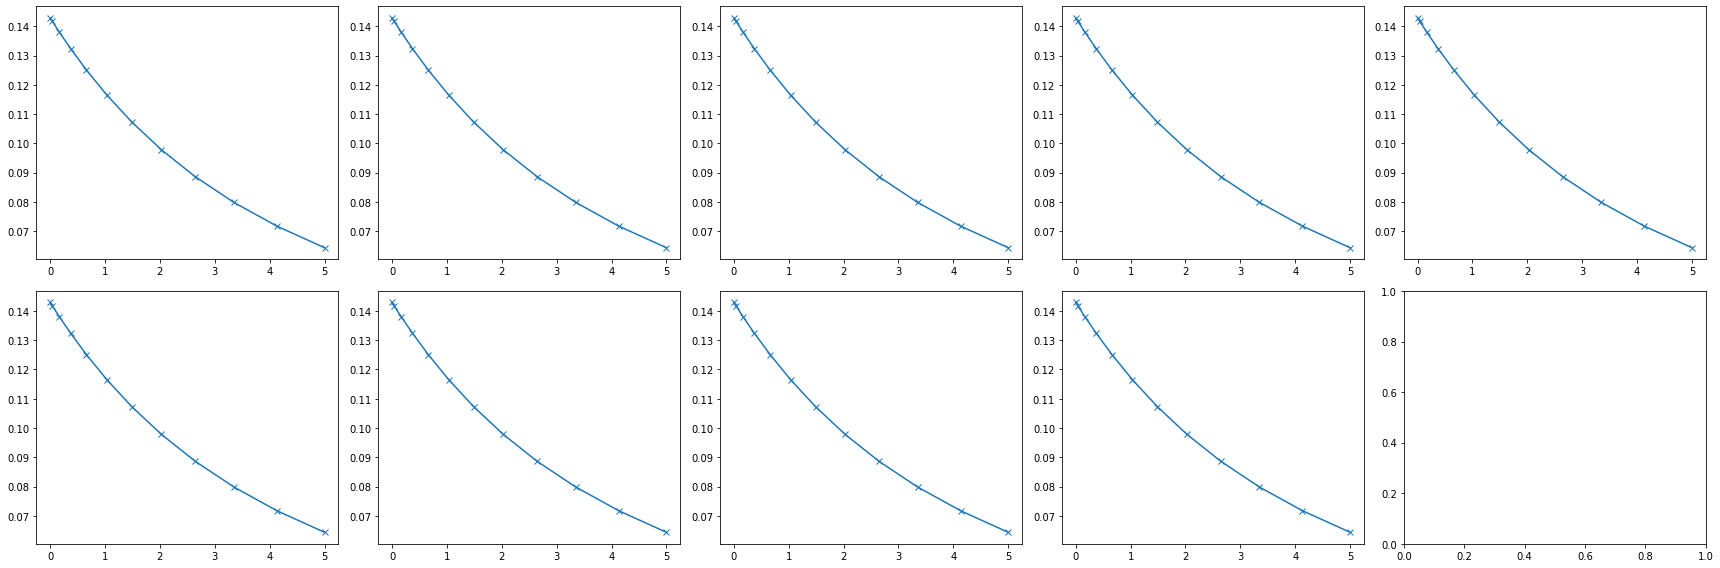

In [27]:
fig, ax = plt.subplots(2, 5, figsize = (24, 8))

for k in range(k_approx - 1): 
    ax[k // 5, k % 5].plot(epsilon_vec, e_sticks_array[:, k], '-x')

fig.tight_layout()

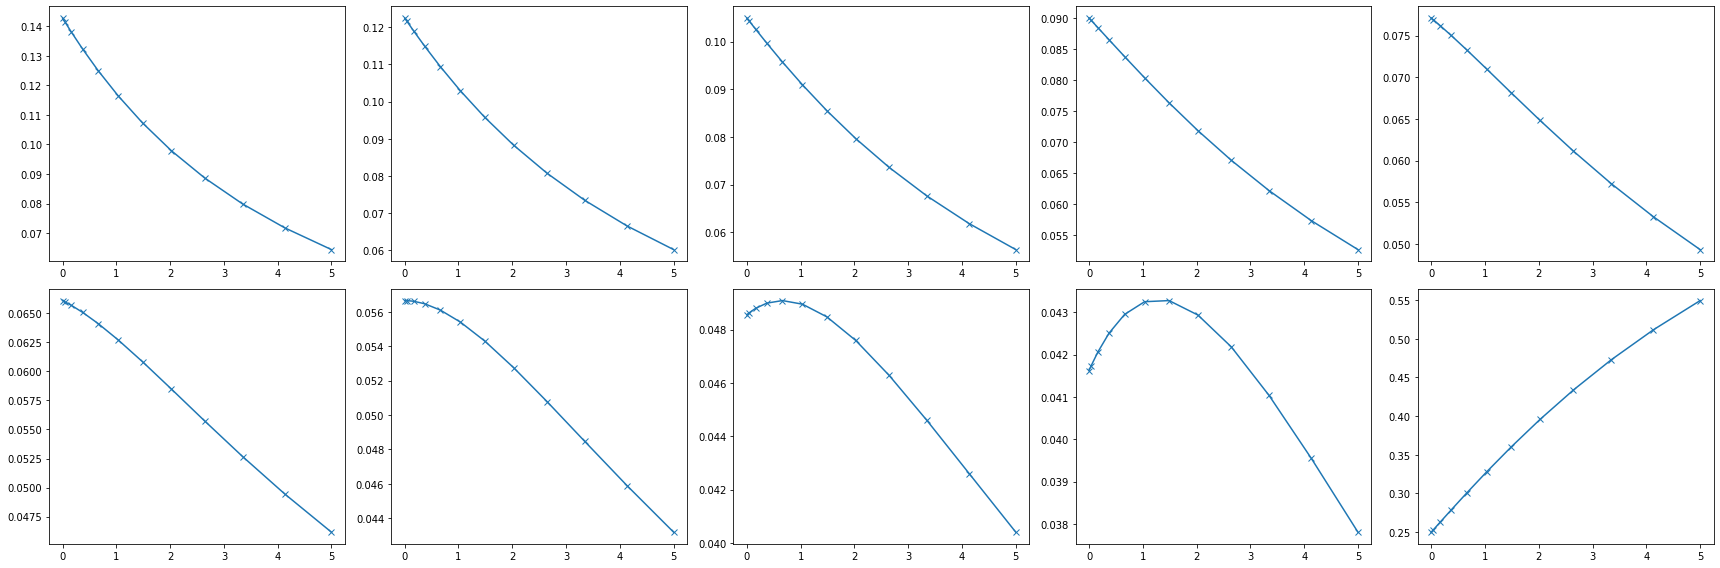

In [28]:
fig, ax = plt.subplots(2, 5, figsize = (24, 8))

for k in range(k_approx): 
    ax[k // 5, k % 5].plot(epsilon_vec, e_admix_array[:, k], '-x')

fig.tight_layout()

# Priors on last refit

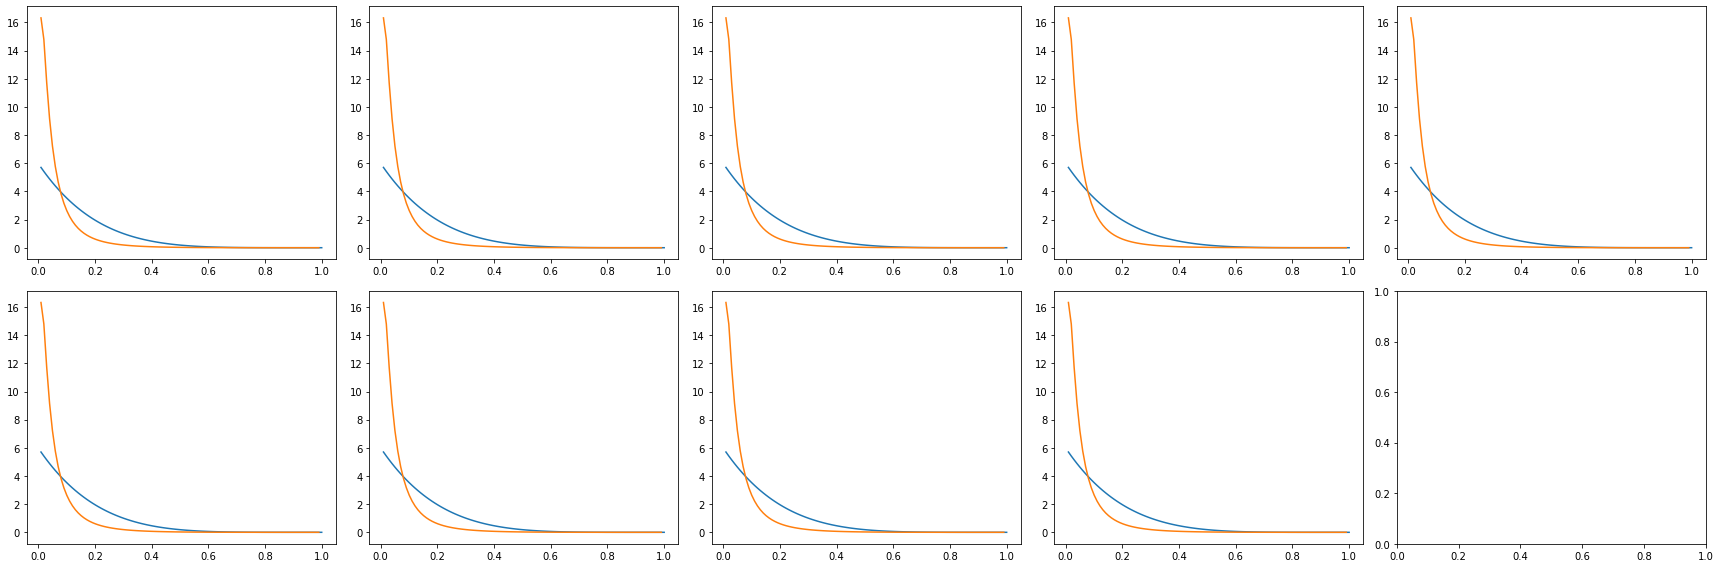

In [29]:
vb_params_dict = vb_params_paragami.fold(vb_refit_list[-1], free = True)

v = np.linspace(0, 1, 100)
beta_pdf = sp.stats.beta.pdf(v, a = 1, b = dp_prior_alpha)

fig, ax = plt.subplots(2, 5, figsize = (24, 8))

for i in range(k_approx - 1): 
    ax[i // 5, i % 5].plot(v, beta_pdf)
    ax[i // 5, i % 5].plot(v, get_logitnormal_pdf(v, 
                                                  vb_params_dict['stick_means'][0, i], 
                                                  vb_params_dict['stick_infos'][0, i]))

fig.tight_layout()